In [2]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:

actions = ['up','down','left','right','Rotate clockwise','Rotate counter-clockwise','shoot']
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        # Define action and observation spaces
        self.grid_size = 1024
        self.grid = np.zeros((self.grid_size, self.grid_size, 3), dtype=np.uint8)
        self.action_space = spaces.Discrete(7)

        self.laction1 = -1
        self.laction2 = -1
        # Initialize agent positions and orientations
        self.agent1_pos = [512, 512]  # Initial position of agent 1
        self.agent2_pos = [256, 256]  # Initial position of agent 2
        self.agent1_facing = 90
        self.agent2_facing = 270

        self.agent_size = 20

        self.reward1 = 0
        self.reward2 = 0

        #self.fig, self.ax = plt.subplots()
        #self.im = self.ax.imshow(self.grid)

    def get_direction(self,agentAttacking,agentDefending):
        x_diff = agentDefending[0] - agentAttacking[0]
        y_diff = agentDefending[1] - agentAttacking[1]
        return math.degrees(math.atan2(y_diff, x_diff))

    def step(self, action1, action2):
        self.reward1 -= 1
        self.reward2 -= 1
        self.laction1 = action1
        self.laction2 = action2
        if action1 == 0:  # Move up
            self.agent1_pos[1] -= 1
        elif action1 == 1:  # Move down
            self.agent1_pos[1] += 1
        elif action1 == 2:  # Move left
            self.agent1_pos[0] -= 1
        elif action1 == 3:  # Move right
            self.agent1_pos[0] += 1
        elif action1 == 4:  # Rotate clockwise
            self.agent1_facing += 10
        elif action1 == 5:  # Rotate counter-clockwise
            self.agent1_facing -= 10
        elif action1 == 6:  # Shoot
            diff = self.agent1_facing - self.get_direction(self.agent1_pos,self.agent2_pos)
            if diff!= 0:
                self.reward1 += 360/abs(diff)
            else:
                self.reward1 += 400

        if action2 == 0:  # Move up
            self.agent2_pos[1] -= 1
        elif action2 == 1:  # Move down
            self.agent2_pos[1] += 1
        elif action2 == 2:  # Move left
            self.agent2_pos[0] -= 1
        elif action2 == 3:  # Move right
            self.agent2_pos[0] += 1
        elif action2 == 4:  # Rotate clockwise
            self.agent2_facing += 10
        elif action2 == 5:  # Rotate counter-clockwise
            self.agent2_facing -= 10
        elif action2 == 6:  # Shoot
            diff = self.agent2_facing - self.get_direction(self.agent2_pos,self.agent1_pos)
            if diff!= 0:
                self.reward2 += 360/abs(diff)
            else:
                self.reward2 += 400

        self.agent1_pos[0] = max(0, min(self.agent1_pos[0], 1023))
        self.agent1_pos[1] = max(0, min(self.agent1_pos[1], 1023))
        self.agent2_pos[0] = max(0, min(self.agent2_pos[0], 1023))
        self.agent2_pos[1] = max(0, min(self.agent2_pos[1], 1023))

        observation1 = self._get_observation1()
        observation2 = self._get_observation2()
        done = self.reward1 >= 10 or self.reward2 >= 10

        return observation1 , observation2, self.reward1, self.reward2, done, {}
    def _get_grid(self):
        self.grid.fill(0)

        # Draw agents on the grid
        self.grid[self.agent1_pos[1] - self.agent_size // 2:self.agent1_pos[1] + self.agent_size // 2,
                  self.agent1_pos[0] - self.agent_size // 2:self.agent1_pos[0] + self.agent_size // 2] = [255, 0, 0]  # Agent 1 (red)
        self.grid[self.agent2_pos[1] - self.agent_size // 2:self.agent2_pos[1] + self.agent_size // 2,
                  self.agent2_pos[0] - self.agent_size // 2:self.agent2_pos[0] + self.agent_size // 2] = [0, 0, 255]  # Agent 2 (blue)

        return self.grid
    def distance(self, pos1, pos2):
        # Calculate Euclidean distance between pos1 and pos2
        return math.sqrt((pos2[0] - pos1[0]) ** 2 + (pos2[1] - pos1[1]) ** 2)
    def _get_observation1(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent1_pos, self.agent2_pos))
        distance = int(self.distance(self.agent1_pos, self.agent2_pos))
        return direction, distance
    def _get_observation2(self):
        # Calculate direction and distance between agents
        direction = int(self.get_direction(self.agent2_pos, self.agent1_pos))
        distance = int(self.distance(self.agent2_pos, self.agent1_pos))
        return direction, distance
    def reset(self):
        self.agent1_pos = [768, 512]
        self.agent2_pos = [256, 512]
        self.agent1_facing = 0
        self.agent2_facing = 180
        self.reward1 = 0
        self.reward2 = 0
        return self._get_observation1(), self._get_observation2()
    def render(self, mode='human'):
        # Visualize the environment
        self.im.set_data(self._get_grid())
        self.ax.set_title(f'Action 1: {actions[self.laction1]}, Action 2: {actions[self.laction2]}')
        plt.pause(0.1)



In [5]:
def train(config = None):
    with wandb.init(config = config):
        config = wandb.config
        env = CustomEnv()

        #Saving the values for plotting and tuning
        avg_loss1_per_ep = []
        avg_loss2_per_ep = []
        
        agg_reward1 = []
        agg_reward2 = []
        # episode_agg =[]
        # loss1_agg =[]
        # loss2_agg =[]

        # Q-learning parameters
        alpha = config.alpha  # Learning rate
        gamma = config.gamma  # Discount factor
        epsilon = config.epsilon  # Epsilon for epsilon-greedy policy
        optimizer = config.optimizer
        num_episodes = 2000  # Number of episodes
        max_steps_per_episode = 100  # Maximum number of steps per episode
        

        # Initialize Q-table
        action_space_size = env.action_space.n
        output_size = env.action_space.n

        model1 = DQN(2, output_size).to(device)
        model2 = DQN(2, output_size).to(device)
        
        if optimizer == "sgd":
            optimizer1 = optim.SGD(model1.parameters(), lr=alpha)
            optimizer2 = optim.SGD(model2.parameters(), lr=alpha)

        elif optimizer == "adam":
            optimizer1 = optim.Adam(model1.parameters(), lr=alpha)
            optimizer2 = optim.Adam(model2.parameters(), lr=alpha)

        loss_fn = nn.MSELoss()

        # Q-learning algorithm
        for episode in range(num_episodes):
            state1,state2 = env.reset()
            total_loss1 = 0
            total_loss2 = 0
            total_reward1 = 0
            total_reward2 = 0

            for step in range(max_steps_per_episode):
                state1_tensor = torch.tensor(state1, dtype=torch.float32).to(device)
                state2_tensor = torch.tensor(state2, dtype=torch.float32).to(device)
                # Choose action
                if np.random.uniform(0, 1) < epsilon:
                    action1 = env.action_space.sample()  # Explore action space
                else:
                    q_values1 = model1(state1_tensor.unsqueeze(0))
                    action1 = torch.argmax(q_values1).item()
                if np.random.uniform(0, 1) < epsilon:
                    action2 = env.action_space.sample()  # Explore action space
                else:
                    q_values2 = model2(state2_tensor.unsqueeze(0))
                    action2 = torch.argmax(q_values2).item()

                # Take action
                next_state1, next_state2, reward1, reward2, done, _ = env.step(action1,action2
                                                    )

                # Update Q-value
                q_values1_next = model1(torch.tensor(next_state1, dtype=torch.float32).to(device).unsqueeze(0))
                q_values2_next = model2(torch.tensor(next_state2, dtype=torch.float32).to(device).unsqueeze(0))
                target1 = reward1 + gamma * torch.max(q_values1_next)
                target2 = reward2 + gamma * torch.max(q_values2_next)
                q_values1_target = model1(state1_tensor.unsqueeze(0)).squeeze(0).to(device)
                q_values2_target = model2(state2_tensor.unsqueeze(0)).squeeze(0).to(device)
                q_values1_target[action1] = target1
                q_values2_target[action2] = target2

                optimizer1.zero_grad()
                optimizer2.zero_grad()
                loss1 = loss_fn(model1(state1_tensor.unsqueeze(0)), q_values1_target.unsqueeze(0))
                loss2 = loss_fn(model2(state2_tensor.unsqueeze(0)), q_values2_target.unsqueeze(0))
                total_loss1 += loss1.item()
                total_loss2 += loss2.item()
                loss1.backward()
                loss2.backward()
                optimizer1.step()
                optimizer2.step()

                total_reward1 += reward1
                total_reward2 += reward2
                state1 = next_state1
                state2 = next_state2
                

                # loss1_agg.append(loss1.item())
                # loss2_agg.append(loss2.item())
                # episode_agg.append(episode)
                # agg_reward1.append(reward1)
                # agg_reward2.append(reward2)

                if done:
                    break
            # Save loss and reward after each episode
            avg_loss1_per_ep.append(total_loss1 / max_steps_per_episode)
            avg_loss2_per_ep.append(total_loss2 / max_steps_per_episode)
            agg_reward1.append(total_reward1)
            agg_reward2.append(total_reward2)

            avg_loss_per_agent = ((total_loss1 + total_loss2) / max_steps_per_episode) / 2

            wandb.log({"loss": avg_loss_per_agent, "epoch": episode})

            print(f"Episode: {episode,step}, Total Reward: {total_reward1,total_reward2}")


In [6]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sz3583 (huskieee). Use `wandb login --relogin` to force relogin


True

In [7]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'alpha': {
        'values': [0.0001, 0.00025, 0.0005, 0.001, 0.01]
        },
    'gamma': {
        'values': [0.9, 0.925, 0.95, 0.975, 0.99]
        },
    'epsilon': {
        'values': [0.01, 0.025, 0.05, 0.75, 0.1]
        },
    }


sweep_config['parameters'] = parameters_dict

sweep_config


{'method': 'random',
 'metric': {'name': 'loss', 'goal': 'minimize'},
 'parameters': {'optimizer': {'values': ['adam', 'sgd']},
  'alpha': {'values': [0.0001, 0.00025, 0.0005, 0.001, 0.01]},
  'gamma': {'values': [0.9, 0.925, 0.95, 0.975, 0.99]},
  'epsilon': {'values': [0.01, 0.025, 0.05, 0.75, 0.1]}}}

In [8]:
sweep_id = wandb.sweep(sweep_config, project="RL")

Create sweep with ID: 3qdzkk71
Sweep URL: https://wandb.ai/huskieee/RL/sweeps/3qdzkk71


In [9]:
wandb.agent(sweep_id, train, count=12)

wandb: Agent Starting Run: 41265pex with config:
wandb: 	alpha: 0.0005
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.9
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-4916.9900724074205, -2717.6112318584)
Episode: (1, 48), Total Reward: (-1190.4853919572, -865.6193690429307)
Episode: (2, 10), Total Reward: (-66, 65.84972790513939)
Episode: (3, 9), Total Reward: (-55, 55.0)
Episode: (4, 9), Total Reward: (-55, 55.0)
Episode: (5, 9), Total Reward: (-55, 55.0)
Episode: (6, 9), Total Reward: (-51.0, 55.0)
Episode: (7, 9), Total Reward: (-55, 55.0)
Episode: (8, 9), Total Reward: (55.0, 47.0)
Episode: (9, 9), Total Reward: (55.0, 55.0)
Episode: (10, 11), Total Reward: (70.00736902459361, -14.0)
Episode: (11, 99), Total Reward: (-3087.6134567791146, -1239.7453125905872)
Episode: (12, 99), Total Reward: (-3095.5185716522965, -3914.5709998098428)
Episode: (13, 56), Total Reward: (-1653, -1025.1465971139858)
Episode: (14, 10), Total Reward: (-66, 65.7074890050168)
Episode: (15, 9), Total Reward: (-55, 55.0)
Episode: (16, 11), Total Reward: (-78, 70.0)
Episode: (17, 99), Total Reward: (-4802.574835506839, -2453.4357523777658)


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▅▂▅█▃▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
loss,0.21481


wandb: Agent Starting Run: pvrwcjs0 with config:
wandb: 	alpha: 0.0001
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.975
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 77), Total Reward: (-2355.0534087299743, -2743.9356224994385)
Episode: (1, 9), Total Reward: (-55, 55.2744740762669)
Episode: (2, 10), Total Reward: (-66, 65.92432625719277)
Episode: (3, 10), Total Reward: (-66, 65.99627212837555)
Episode: (4, 10), Total Reward: (-66, 65.64697878270705)
Episode: (5, 10), Total Reward: (-66, 65.64572804411519)
Episode: (6, 9), Total Reward: (-55, 55.0)
Episode: (7, 9), Total Reward: (-55, 55.0)
Episode: (8, 9), Total Reward: (-55, 55.0)
Episode: (9, 9), Total Reward: (-55, 55.0)
Episode: (10, 9), Total Reward: (-55, 55.0)
Episode: (11, 9), Total Reward: (-55, 55.0)
Episode: (12, 9), Total Reward: (-55, 55.0)
Episode: (13, 9), Total Reward: (-55, 55.0)
Episode: (14, 9), Total Reward: (-55, 55.0)
Episode: (15, 9), Total Reward: (-55, 55.0)
Episode: (16, 9), Total Reward: (-55, 55.0)
Episode: (17, 9), Total Reward: (-55, 55.0)
Episode: (18, 9), Total Reward: (-45.18181818181817, 55.0)
Episode: (19, 10), Total Reward: (-66, 65.9925296753757)
Ep

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
loss,0.93008


wandb: Agent Starting Run: l6m1mk5z with config:
wandb: 	alpha: 0.00025
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.925
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 22), Total Reward: (-183.98417531575217, -43.15665526885522)
Episode: (1, 9), Total Reward: (-55, 55.00123212993636)
Episode: (2, 9), Total Reward: (-35.0, 55.0)
Episode: (3, 9), Total Reward: (-55, 55.0)
Episode: (4, 9), Total Reward: (-55, 55.0)
Episode: (5, 9), Total Reward: (-55, 55.0)
Episode: (6, 9), Total Reward: (-55, 55.0)
Episode: (7, 9), Total Reward: (-55, 55.0)
Episode: (8, 9), Total Reward: (-55, 55.0)
Episode: (9, 10), Total Reward: (-66, 65.64697878270705)
Episode: (10, 58), Total Reward: (-1770, -873.3700367154061)
Episode: (11, 9), Total Reward: (-55, 55.0)
Episode: (12, 9), Total Reward: (-55, 55.0)
Episode: (13, 9), Total Reward: (-55, 55.0)
Episode: (14, 10), Total Reward: (-49.619699558077265, 65.98881638512668)
Episode: (15, 9), Total Reward: (-55, 55.018896553738635)
Episode: (16, 9), Total Reward: (-55, 55.0)
Episode: (17, 9), Total Reward: (-55, 55.068485579222546)
Episode: (18, 9), Total Reward: (-55, 55.00122266444586)
Episode: (19, 9), Total Re

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▂▃▂▂▂▂▂▂▂▃▂▂▂▅▂▂█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,1999
loss,0.54642


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s7bqc2bp with config:
wandb: 	alpha: 0.00025
wandb: 	epsilon: 0.025
wandb: 	gamma: 0.975
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 9), Total Reward: (55.16173689839536, -55)
Episode: (1, 9), Total Reward: (55.0074650194603, 46.99254425675113)
Episode: (2, 9), Total Reward: (55.0, 35.0)
Episode: (3, 9), Total Reward: (55.00493002958905, -55)
Episode: (4, 9), Total Reward: (55.03829621749958, -55)
Episode: (5, 11), Total Reward: (58.288411587352336, -78)
Episode: (6, 9), Total Reward: (55.0, -55)
Episode: (7, 9), Total Reward: (55.0, -55)
Episode: (8, 9), Total Reward: (55.0, -55)
Episode: (9, 9), Total Reward: (55.0, -55)
Episode: (10, 9), Total Reward: (55.00124416991005, -55)
Episode: (11, 12), Total Reward: (77.44107733591974, -91)
Episode: (12, 95), Total Reward: (-620.4353878994417, -4547.623219841709)
Episode: (13, 49), Total Reward: (-103.66419512380514, -1275)
Episode: (14, 9), Total Reward: (55.0, -55)
Episode: (15, 9), Total Reward: (55.0, -55)
Episode: (16, 11), Total Reward: (66.03751961196393, -78)
Episode: (17, 99), Total Reward: (-4070.0, -2634.313089785899)
Episode: (18, 9), Total Rewar

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▆█▆▂▄▂▄▅▁▂▁▁▄▆▁▆▄▁▅▁█▁▁▁▁▁▁▁▁▁▅▃▁▁▄▅▁▁
epoch,1999
loss,21.42471


wandb: Agent Starting Run: zhym6o0v with config:
wandb: 	alpha: 0.00025
wandb: 	epsilon: 0.01
wandb: 	gamma: 0.9
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-4370.367068091513, -4775.539752258254)
Episode: (1, 21), Total Reward: (-253, -198.69852310539324)
Episode: (2, 9), Total Reward: (-55, 55.0)
Episode: (3, 9), Total Reward: (-55, 55.0)
Episode: (4, 9), Total Reward: (-35.0, 55.0)
Episode: (5, 9), Total Reward: (55.0, 55.0)
Episode: (6, 9), Total Reward: (55.0, 55.0)
Episode: (7, 9), Total Reward: (55.0, 55.0)
Episode: (8, 9), Total Reward: (55.0, 55.0)
Episode: (9, 9), Total Reward: (55.0, 55.0)
Episode: (10, 9), Total Reward: (55.0, 55.0)
Episode: (11, 9), Total Reward: (55.0, 55.0)
Episode: (12, 9), Total Reward: (55.0, 55.0)
Episode: (13, 9), Total Reward: (55.0, 55.0)
Episode: (14, 9), Total Reward: (55.0, 55.0)
Episode: (15, 9), Total Reward: (55.0, 55.0)
Episode: (16, 9), Total Reward: (55.0, 55.0)
Episode: (17, 9), Total Reward: (55.0, 55.0)
Episode: (18, 9), Total Reward: (55.0, 55.0)
Episode: (19, 9), Total Reward: (55.0, 55.0)
Episode: (20, 9), Total Reward: (55.0, 55.0)
Episode: (21, 9), Tot

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▂▃▃▃▄▄▇▁▄▂▇▁▂▁▂▂▂▆▁▁▁▁▂▃▁▂▁▁▁▁▁▁▁▁█▁▁▁▁
epoch,1999
loss,0.12422


wandb: Agent Starting Run: 77d1rzre with config:
wandb: 	alpha: 0.00025
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.9
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 9), Total Reward: (55.0, -55)
Episode: (1, 16), Total Reward: (-60.77425773395464, 70.28294459881114)
Episode: (2, 99), Total Reward: (-1820.9586465424459, -845.7315631253884)
Episode: (3, 11), Total Reward: (54.32365229802238, -55.91153918346433)
Episode: (4, 57), Total Reward: (-648.2580885147305, -885.9723787257883)
Episode: (5, 12), Total Reward: (-59.15143606742484, 74.78942035864966)
Episode: (6, 44), Total Reward: (-646.8193807570233, -374.59386737691966)
Episode: (7, 9), Total Reward: (55.05752259768606, -55)
Episode: (8, 11), Total Reward: (64.59314613288295, -78)
Episode: (9, 25), Total Reward: (88.67596765720941, -351)
Episode: (10, 11), Total Reward: (68.05409379250776, -78)
Episode: (11, 99), Total Reward: (-2337.5027106964512, -2974.7209876177617)
Episode: (12, 17), Total Reward: (-62.16733374305901, -171)
Episode: (13, 9), Total Reward: (55.180491246704456, -55)
Episode: (14, 20), Total Reward: (-190.97516513744128, 48.434932678625245)
Episode: (15, 10), Tot

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▂▂▇▇▂▆▄▇▁▁▇▂▂▆▁▂▂▇▂▂█▅▇▁▄▁▃▁▂▆▂▁▇█▂▁▁▂▇
epoch,1999
loss,14.83373


wandb: Agent Starting Run: ovpqr9gw with config:
wandb: 	alpha: 0.0001
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.9
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-4585.023648166463, -5050)
Episode: (1, 9), Total Reward: (55.0, -55)
Episode: (2, 9), Total Reward: (55.0, -55)
Episode: (3, 9), Total Reward: (55.004920503434136, -43.0)
Episode: (4, 9), Total Reward: (55.20077223498018, -55)
Episode: (5, 11), Total Reward: (58.05598764595214, -78)
Episode: (6, 9), Total Reward: (55.20579294496463, -55)
Episode: (7, 99), Total Reward: (-3495.6424831124446, -4837.37529254779)
Episode: (8, 99), Total Reward: (-3646.0403240388723, -5050)
Episode: (9, 99), Total Reward: (-4195.8583212136255, -4768.382772702583)
Episode: (10, 99), Total Reward: (-4918.4649351694325, -5046.5128124932835)
Episode: (11, 99), Total Reward: (-4360.857142857147, -5050)
Episode: (12, 99), Total Reward: (-3958.4196383088847, -5050)
Episode: (13, 99), Total Reward: (-2755.1765285789616, -5050)
Episode: (14, 99), Total Reward: (-4077.358060936785, -4960.391457394987)
Episode: (15, 99), Total Reward: (-4805.711527609538, -4659.998298745071)
Episode: 

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
loss,4.69738


wandb: Agent Starting Run: rd78j7u5 with config:
wandb: 	alpha: 0.001
wandb: 	epsilon: 0.75
wandb: 	gamma: 0.9
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 75), Total Reward: (-1641.2475105799242, -2452.3800696620387)
Episode: (1, 99), Total Reward: (-3675.280020461803, -4138.703561570727)
Episode: (2, 99), Total Reward: (-3927.400568609765, -3925.4890301152614)
Episode: (3, 99), Total Reward: (-3419.2150445362377, -3736.9226788276515)
Episode: (4, 99), Total Reward: (-3443.5521812732736, -4054.188032156578)
Episode: (5, 99), Total Reward: (-3971.074190936486, -4334.204891424927)
Episode: (6, 99), Total Reward: (-2725.7848156046775, -3820.545078155237)
Episode: (7, 99), Total Reward: (-3147.4307275791343, -4083.1577306568424)
Episode: (8, 99), Total Reward: (-3849.595678288282, -3761.709964967894)
Episode: (9, 99), Total Reward: (-3495.5047360452936, -4342.1357703263175)
Episode: (10, 99), Total Reward: (-4244.906106932443, -3293.317034582679)
Episode: (11, 99), Total Reward: (-3565.2040343268754, -3145.986849799062)
Episode: (12, 99), Total Reward: (-3025.8383622578203, -3673.5592248143353)
Episode: (13, 99), Total Reward: (

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▂▂▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▄▁▁▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁
epoch,1999
loss,60.28385


wandb: Agent Starting Run: 7665omtp with config:
wandb: 	alpha: 0.01
wandb: 	epsilon: 0.05
wandb: 	gamma: 0.99
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-4580.458850297229, -3683.385013001292)
Episode: (1, 99), Total Reward: (-5032.705930198083, -5050)
Episode: (2, 99), Total Reward: (-5020.547463391958, -5050)
Episode: (3, 99), Total Reward: (-5050, -5050)
Episode: (4, 99), Total Reward: (-2702.0, -5050)
Episode: (5, 99), Total Reward: (-5050, -4600.899613839803)
Episode: (6, 15), Total Reward: (62.947368421052616, -136)
Episode: (7, 99), Total Reward: (-3974.394527431567, -5050)
Episode: (8, 9), Total Reward: (55.0, -55)
Episode: (9, 99), Total Reward: (-3880.0, -5050)
Episode: (10, 99), Total Reward: (-5009.730346555225, -5050)
Episode: (11, 99), Total Reward: (-4865.766743188804, -5034.530296945073)
Episode: (12, 99), Total Reward: (-5050, -5050)
Episode: (13, 99), Total Reward: (-4884.0, -5010.307692307685)
Episode: (14, 99), Total Reward: (-2623.4271728789604, -5050)
Episode: (15, 9), Total Reward: (55.02612756811101, -55)
Episode: (16, 9), Total Reward: (55.0, -55)
Episode: (17, 9), Total Reward:

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁█
epoch,1999
loss,nan


wandb: Agent Starting Run: quqebb7i with config:
wandb: 	alpha: 0.00025
wandb: 	epsilon: 0.75
wandb: 	gamma: 0.975
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-3611.6014640662343, -4027.3354858480902)
Episode: (1, 99), Total Reward: (-3951.628453490854, -3185.8233134397115)
Episode: (2, 99), Total Reward: (-3192.3874538455307, -3941.4233692650214)
Episode: (3, 99), Total Reward: (-3363.1596134783676, -4524.275647749322)
Episode: (4, 99), Total Reward: (-4748.847581255195, -4540.032260474514)
Episode: (5, 99), Total Reward: (-4470.199417058858, -4605.470829452706)
Episode: (6, 99), Total Reward: (-4838.097075250831, -2628.563521191709)
Episode: (7, 99), Total Reward: (-2436.4401089393054, -2371.2337260313966)
Episode: (8, 99), Total Reward: (-4078.808901391715, -4057.6429525696726)
Episode: (9, 99), Total Reward: (-4550.842945485083, -3762.5969111873997)
Episode: (10, 99), Total Reward: (-2701.0050704113087, -4014.3010019611443)
Episode: (11, 99), Total Reward: (-1397.8867249609855, -4765.416147616368)
Episode: (12, 99), Total Reward: (-3772.7616867656743, -4313.842006955418)
Episode: (13, 99), Total Reward: (

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▃▇▆▆▇▇█▇█▇▆▄▅▅▇▄▅▄▅▁▅▅▄█▆▇▇▇▆▇▆▁▃▆▅▃▃▄▆▄
epoch,1999
loss,118.41782


wandb: Agent Starting Run: k2e9a39m with config:
wandb: 	alpha: 0.001
wandb: 	epsilon: 0.1
wandb: 	gamma: 0.925
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 9), Total Reward: (-55, 55.044629223411924)
Episode: (1, 99), Total Reward: (-5004.276131483984, -4262.733262612634)
Episode: (2, 99), Total Reward: (-4732.681551021347, -5028.882945487256)
Episode: (3, 99), Total Reward: (-5050, -4741.147382020001)
Episode: (4, 99), Total Reward: (-5050, -5050)
Episode: (5, 99), Total Reward: (-4954.12839489372, -4893.883620198983)
Episode: (6, 99), Total Reward: (-5050, -5004.464424238399)
Episode: (7, 99), Total Reward: (-4694.268564801559, -4940.753199463862)
Episode: (8, 99), Total Reward: (-4921.087901298208, -5005.05427884611)
Episode: (9, 99), Total Reward: (-5050, -5012.415634502574)
Episode: (10, 99), Total Reward: (-4759.43002633545, -4801.694470967088)
Episode: (11, 99), Total Reward: (-5050, -4992.02686170724)
Episode: (12, 99), Total Reward: (-5050, -4876.431915683127)
Episode: (13, 99), Total Reward: (-4777.41233398364, -5037.118946242284)
Episode: (14, 99), Total Reward: (-5050, -4881.251979789555)
Episode: (15, 99), Total 

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▁▁▄▂▁▁▁▁▃▂▃▂▃▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1999
loss,4.04467


wandb: Agent Starting Run: 9moeufhr with config:
wandb: 	alpha: 0.0001
wandb: 	epsilon: 0.025
wandb: 	gamma: 0.95
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Episode: (0, 99), Total Reward: (-5050, -4708.4140373933515)
Episode: (1, 99), Total Reward: (-5050, -4867.610141636436)
Episode: (2, 13), Total Reward: (-105, 67.42105263157893)
Episode: (3, 11), Total Reward: (-57.15789473684211, 66.0)
Episode: (4, 10), Total Reward: (-66, 65.79627570365062)
Episode: (5, 99), Total Reward: (-4895.726166853134, -4068.9626652058014)
Episode: (6, 99), Total Reward: (-3688.377371982638, -3581.7695036390946)
Episode: (7, 99), Total Reward: (-4984.831819857629, -4911.280935772407)
Episode: (8, 99), Total Reward: (-4752.01598712818, -3996.9345483627885)
Episode: (9, 9), Total Reward: (55.0, -55)
Episode: (10, 9), Total Reward: (55.00378678439188, -55)
Episode: (11, 99), Total Reward: (-2432.9752945024466, -4960.032464744837)
Episode: (12, 9), Total Reward: (55.0, 55.0)
Episode: (13, 9), Total Reward: (50.89473684210526, 55.0)
Episode: (14, 9), Total Reward: (13.0, 55.0)
Episode: (15, 12), Total Reward: (-91, 84.92170740519907)
Episode: (16, 99), Total Rewar

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▅▁▁▁▆█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▂▆▁▁▁▁▁▁▁▁▁
epoch,1999
loss,4.53532


In [9]:
def visualize_q_map(model):
    direction_values = list(range(360))
    distance_values = list(range(1024))
    q_map = np.zeros((len(direction_values), len(distance_values)))

    for direction in direction_values:
        for distance in distance_values:
            state = [direction, distance]
            state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
            q_values = model(state_tensor.unsqueeze(0))
            action = torch.argmax(q_values).item()
            q_map[direction][distance] = action

    plt.imshow(q_map, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Action')
    plt.xlabel('Distance')
    plt.ylabel('Direction')
    plt.title('Q-Map')
    plt.show()


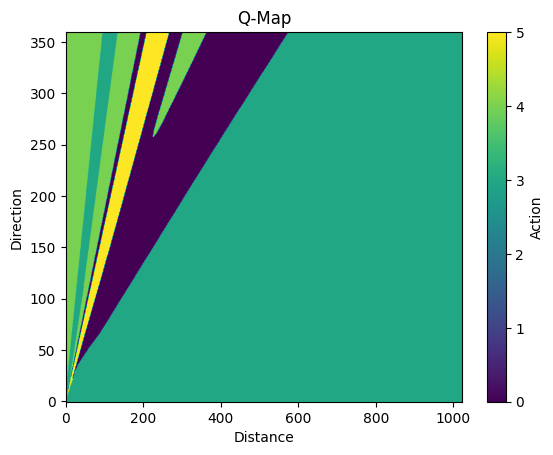

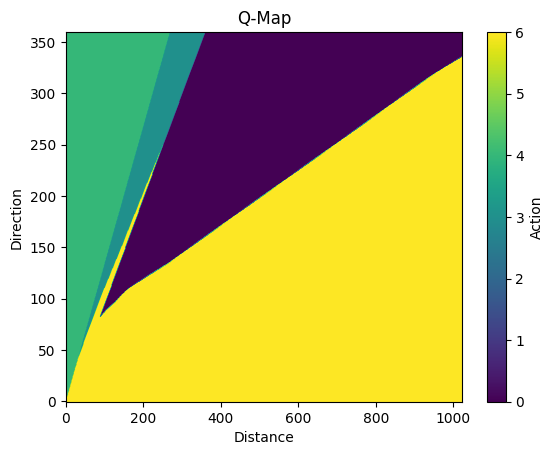

In [10]:
visualize_q_map(model1)
visualize_q_map(model2)

<function matplotlib.pyplot.show(close=None, block=None)>

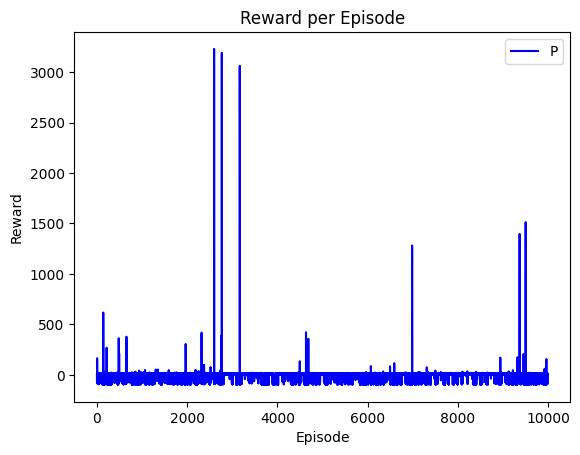

In [11]:
plt.plot(episode_agg, agg_reward1,color='blue')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend('Player 1')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

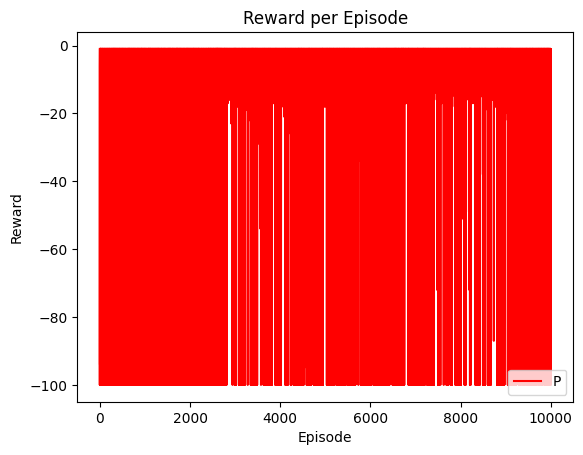

In [12]:
plt.plot(episode_agg, agg_reward2,color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.legend('Player 1')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

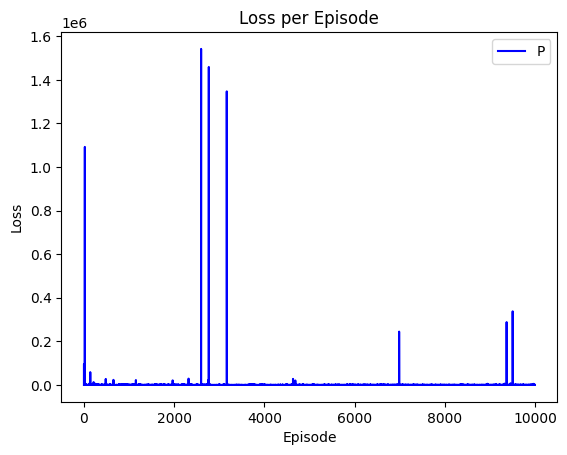

In [13]:
plt.plot(episode_agg, loss1_agg,color='blue')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode')
plt.legend('Player 1')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

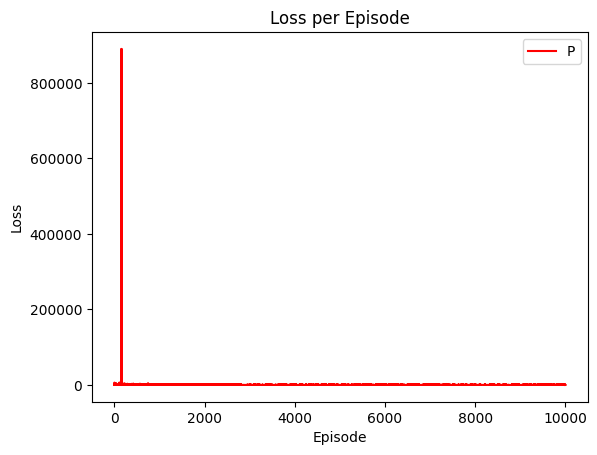

In [14]:
plt.plot(episode_agg, loss2_agg,color='red')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Loss per Episode')
plt.legend('Player 2')
plt.show()

In [15]:
print(loss2_agg)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

